In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import pandas as pd
from scipy import signal
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import os
from tqdm.notebook import tqdm
import math
import warnings

#from multi_traps import *
#from multiprocessing import Pool

## Original Convolution Assumptions (REPLACED)

In [2]:
def trapezoid_impulse(t, tau, T1, T2):
    # T2 >= T1
    truncated_ramp = lambda t, T1: np.concatenate((t[:np.argmin(np.abs(t-T1))+1], 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T1))-1)))
    moving_average = lambda t, T2: np.concatenate((np.ones(np.argmin(np.abs(t-T2))+1), 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T2))-1)))
    h1, h2 = truncated_ramp(t, T1), moving_average(t, T2)
    h1_t_T2, h2_t_T1 = np.roll(truncated_ramp(t, T1), T2), np.roll(moving_average(t, T2), T1)
    h = h1 + tau*h2 + (T1-tau)*h2_t_T1 - h1_t_T2
    return h

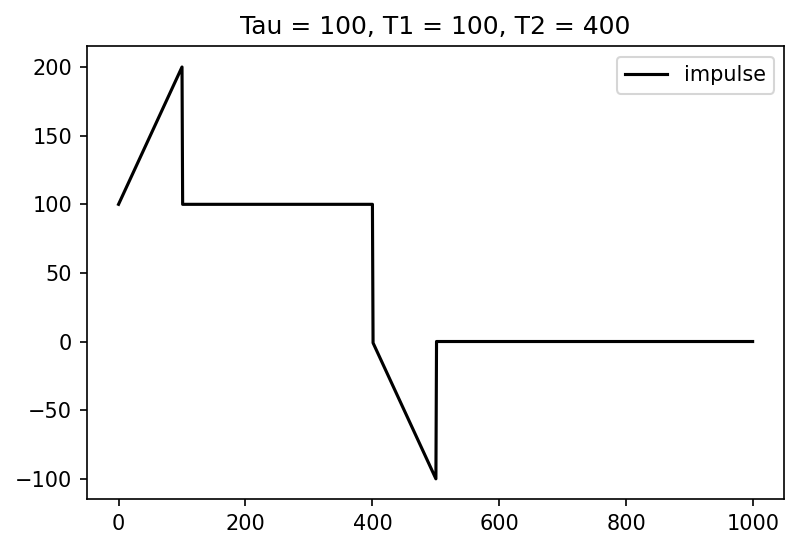

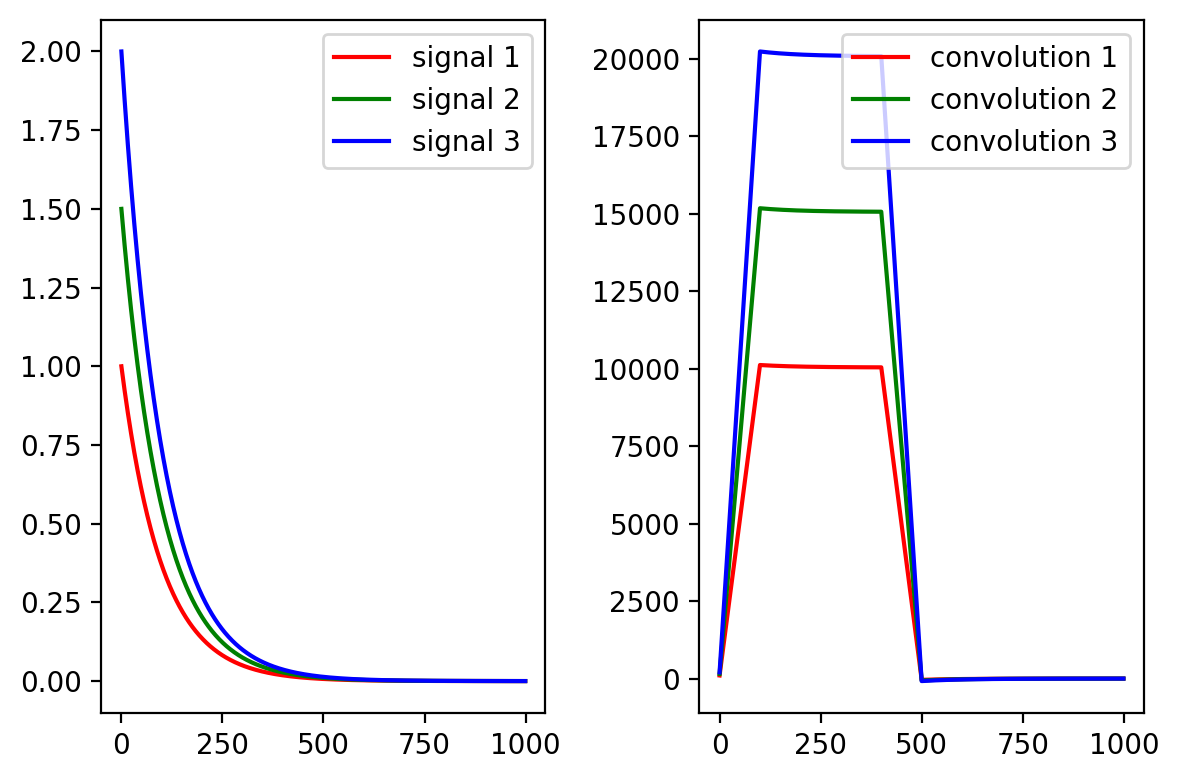

In [3]:
ln = 1000
t = np.linspace(0, 1000, ln)

test_exp = np.exp(-t/100)
test_exp2 = 1.5*np.exp(-t/100)
test_exp3 = 2*np.exp(-t/100)

tau, T1, T2 = 100, 100, 400
test = trapezoid_impulse(t, tau, T1, T2)

fig = plt.figure(dpi=150)
plt.plot(test, color='black', label='impulse')
plt.title('Tau = {}, T1 = {}, T2 = {}'.format(tau, T1, T2))
plt.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200)
ax1.plot(test_exp, c='red', label='signal 1')
ax1.plot(test_exp2, c='green', label='signal 2')
ax1.plot(test_exp3, c='blue', label='signal 3')
ax1.legend()

ax2.plot(np.convolve(test_exp, test)[:ln], c='red', label='convolution 1')
ax2.plot(np.convolve(test_exp2, test)[:ln], c='green', label='convolution 2')
ax2.plot(np.convolve(test_exp3, test)[:ln], c='blue', label='convolution 3')
ax2.legend()
plt.tight_layout()
plt.show()

## New Trapezoidal Shaping Approach

In [2]:
def determine_rise(signal, sigma=8, window=20, offset=15):
    noise_samp = signal[:500]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    
    grad = np.gradient(np.where(signal > mean+sigma*std, signal, 0))
    
    grad_pos, grad_neg = np.argwhere(grad>2), np.argwhere(grad<-2)
    
    rise_start = 0
    for gp in grad_pos:
        close = False
        for gn in grad_neg:
            if gn-gp < window and gn-gp > 0:
                close = True
        if not close:
            rise_start = gp
            break
    
    return int(rise_start-offset)

def delay_signal(signal, delay=2000, w=500, seed=69):
    np.random.seed(seed)
    noise_samp = signal[:w]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    noise = np.random.normal(mean, 0.9*std, delay)
    return np.hstack([noise, signal])

def dkl(signal, i, k, l, w):
    signal = delay_signal(signal, delay=w)
    vj = signal[i+w:i+w+w]
    vjk = signal[i-k+w:i+w+w-k]
    vjl = signal[i-l+w:i+w+w-l]
    vjkl = signal[i-k-l+w:i+w+w-k-l]
    return vj - vjk - vjl + vjkl
    
def s(signal, start_rise, tau, peaking_time, gap_time, w=0):
    if w == 0:
        w = int(round(2.5*peaking_time+gap_time, 0))
    ss = []
    dkl_s = dkl(signal, start_rise, peaking_time, peaking_time+gap_time, w)
    for j in range(w):
        if j == 0:
            ss.append(0)
        else:
            ss.append(ss[j-1]*(1+1/tau)+ dkl_s[j])
    return np.array(ss)

In [39]:
#f = h5py.File('Data/Test-928/Cs137-24in-2min.h5', 'r')
f = h5py.File('/Users/raptor/Research/python3316/Data/Test-928/Cs137-24in-1min_5.h5')

test_data = pd.DataFrame(f['raw_data'])
test_np = test_data.to_numpy()

sat_i = []
for i in range(len(test_np)):
    if test_np[i][1300] == 16383:
        sat_i.append(i)

print(len(test_np))

7432


In [2]:
datas = []

for i in range(27, 29):
    f = h5py.File('/Users/raptor/Research/python3316/Data/Test-928/Co60-36in-1min_{}.h5'.format(i), 'r')
    dataframe = pd.DataFrame(f['raw_data'])
    data_np = dataframe.to_numpy()
    
    datas.append(data_np)
merge_data = np.concatenate(datas)

fmerged = h5py.File('Data/Test-928/Co60-36in-2min.h5', 'w')
fmerged.create_dataset('raw_data', data=merge_data)

fmerged.close()

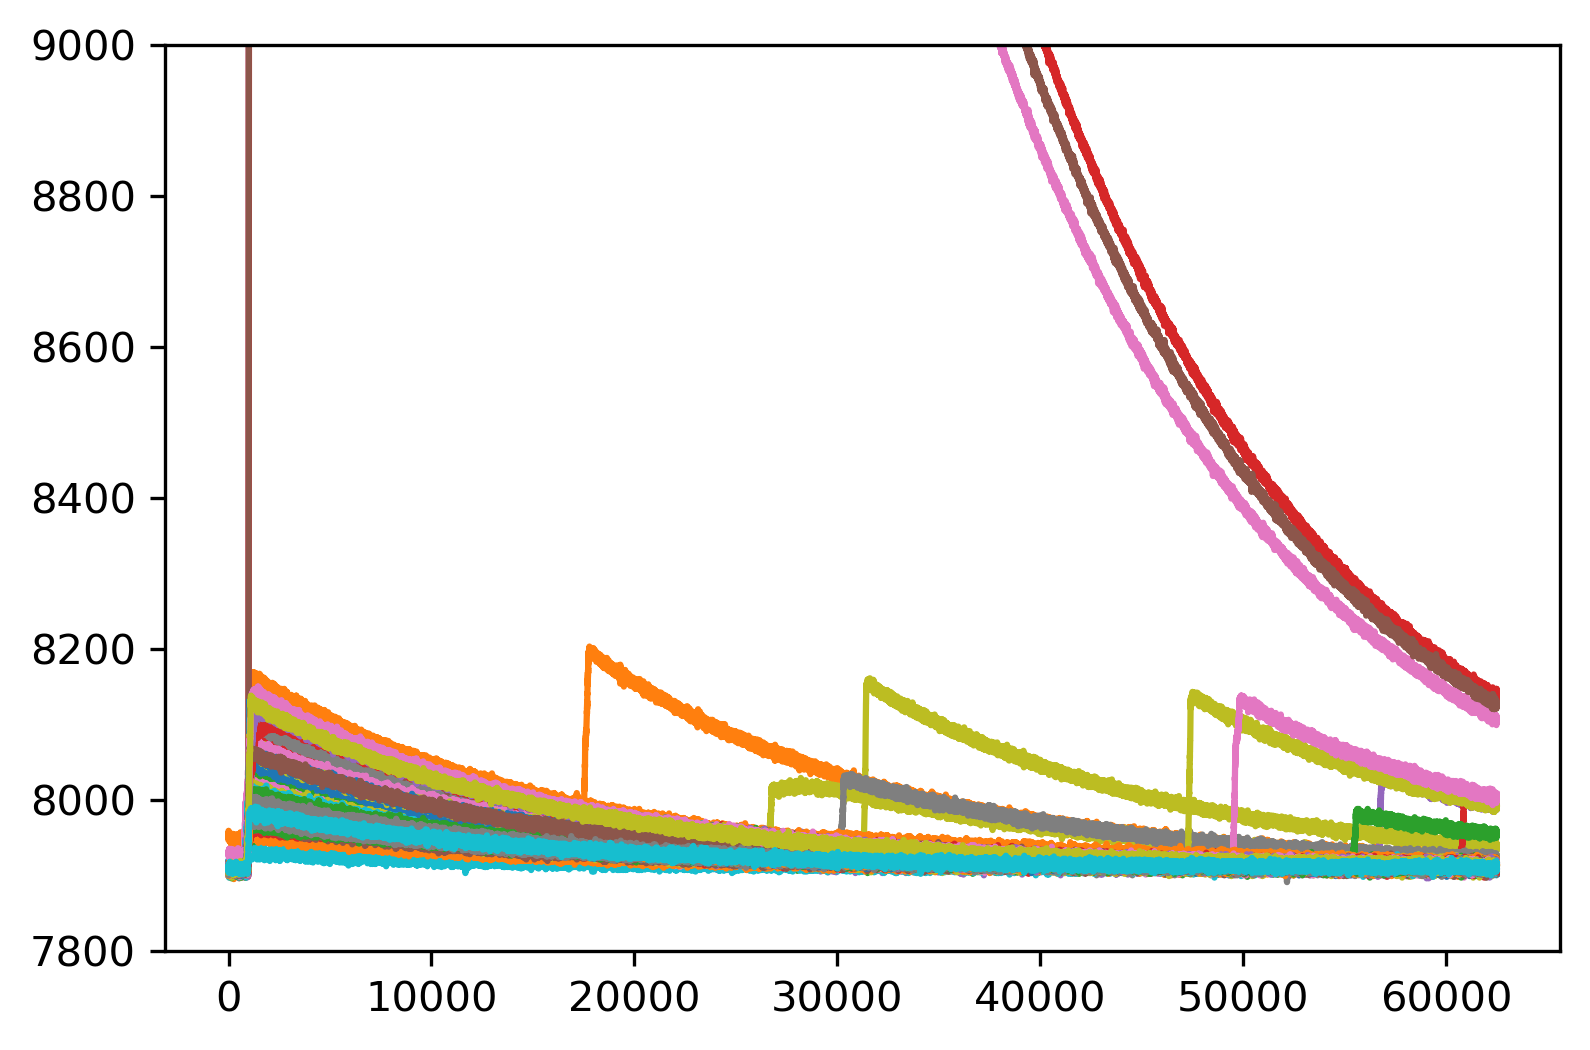

In [4]:
plt.figure(dpi=300)
for i in range(250):
    plt.plot(test_np[i])
plt.ylim(7800, 9000)
plt.show()

In [5]:
p, g = 370, 400
ra = 51
traps = []
for i, pulse in enumerate(tqdm(test_np, desc="Peak = {}, Gap = {}".format(p, g), leave=False)):
    fs = savgol_filter(pulse, ra, 0)

    trap = s(fs, determine_rise(fs), 15000, p, g)
    traps.append(trap)
trap_np = np.concatenate(traps).reshape(len(traps), len(traps[0]))

Peak = 370, Gap = 400:   0%|          | 0/7432 [00:00<?, ?it/s]

In [8]:
rises = []
fss = []
for pulse in test_np:
    fs = savgol_filter(pulse, ra, 0)
    rises.append(determine_rise(fs))
    fss.append(fs)
fss = np.array(fss)

In [11]:
np.array(fss).shape

(7432, 62500)

In [42]:
ra = 51
peak, gap = 400, 200
#peak_expl, gap_expl = 100, 200
peak_min, peak_max = 220, 520
gap_min, gap_max = 0, 500

rises = []
fss = []
for pulse in tqdm(test_np, desc='Filtering', leave=False):
    fs = savgol_filter(pulse, ra, 0)
    rises.append(determine_rise(fs))
    fss.append(fs)
fss = np.array(fss)

p = 530
#for p in tqdm(range(peak_min, peak_max+10, 10), desc='Iterating peak from {} to {}'.format(peak_min, peak_max), leave=False):
    #for g in tqdm(range(100, 310, 10), leave=False):
for g in tqdm(range(gap_min, gap_max+10, 10), desc='Iterating gap from {} to {}'.format(gap_min, gap_max)):
    if 'Cs137_p{}_g{}.npy'.format(p, g) in [f for f in os.listdir('Data/Fit-Data-New/') if f != '.DS_Store']:
        #print('File (Cs137_p{}_g{}.npy) already exists, skipping to next combo'.format(peak, g))
        continue
    traps = []
    for i, pulse in enumerate(tqdm(test_np, desc="Peak = {}, Gap = {}".format(p, g), leave=False)):
        trap = s(fss[i], rises[i], 15000, p, g)
        traps.append(trap)
    trap_np = np.concatenate(traps).reshape(len(traps), len(traps[0]))
    np.save('Data/Fit-Data-New/Cs137_p{}_g{}.npy'.format(p, g), trap_np)

Filtering:   0%|          | 0/7432 [00:00<?, ?it/s]

Iterating gap from 0 to 500:   0%|          | 0/51 [00:00<?, ?it/s]

Peak = 530, Gap = 0:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 10:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 20:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 30:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 40:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 50:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 60:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 70:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 80:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 90:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 100:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 110:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 120:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 130:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 140:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 150:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 160:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 170:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 180:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 190:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 200:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 210:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 220:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 230:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 240:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 250:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 260:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 270:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 280:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 290:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 300:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 310:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 320:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 330:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 340:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 350:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 360:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 370:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 380:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 390:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 400:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 410:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 420:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 430:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 440:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 450:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 460:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 470:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 480:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 490:   0%|          | 0/7432 [00:00<?, ?it/s]

Peak = 530, Gap = 500:   0%|          | 0/7432 [00:00<?, ?it/s]

In [108]:
fs = savgol_filter(test_np[0], ra, 0)
rise = determine_rise(fs)

1581

In [102]:
trap_np

array([[0.00000000e+00, 6.59240747e+00, 1.17782166e+01, ...,
        2.48302534e+04, 2.46858107e+04, 2.45422604e+04],
       [0.00000000e+00, 3.05362106e-01, 1.36442057e+00, ...,
        1.09502928e+04, 1.07928660e+04, 1.06360365e+04],
       [0.00000000e+00, 3.24066619e+00, 7.72922728e+00, ...,
        9.21167069e+03, 9.12938284e+03, 9.04718754e+03],
       ...,
       [0.00000000e+00, 1.94327971e+00, 2.49114989e+00, ...,
        8.30290714e+02, 8.10149988e+02, 7.90262822e+02],
       [0.00000000e+00, 3.34387982e+00, 7.41810851e+00, ...,
        1.40866575e+03, 1.37238711e+03, 1.33643939e+03],
       [0.00000000e+00, 4.61085050e+00, 8.29740258e+00, ...,
        2.62081821e+03, 2.52771842e+03, 2.43553400e+03]])

In [ ]:
8 it/s, 18 it/s

In [103]:
spectra = []

spec_trap = []

for trap in trap_np:
    if max(trap) < 365000:
        spectra.append(max(trap))
        spec_trap.append(trap)

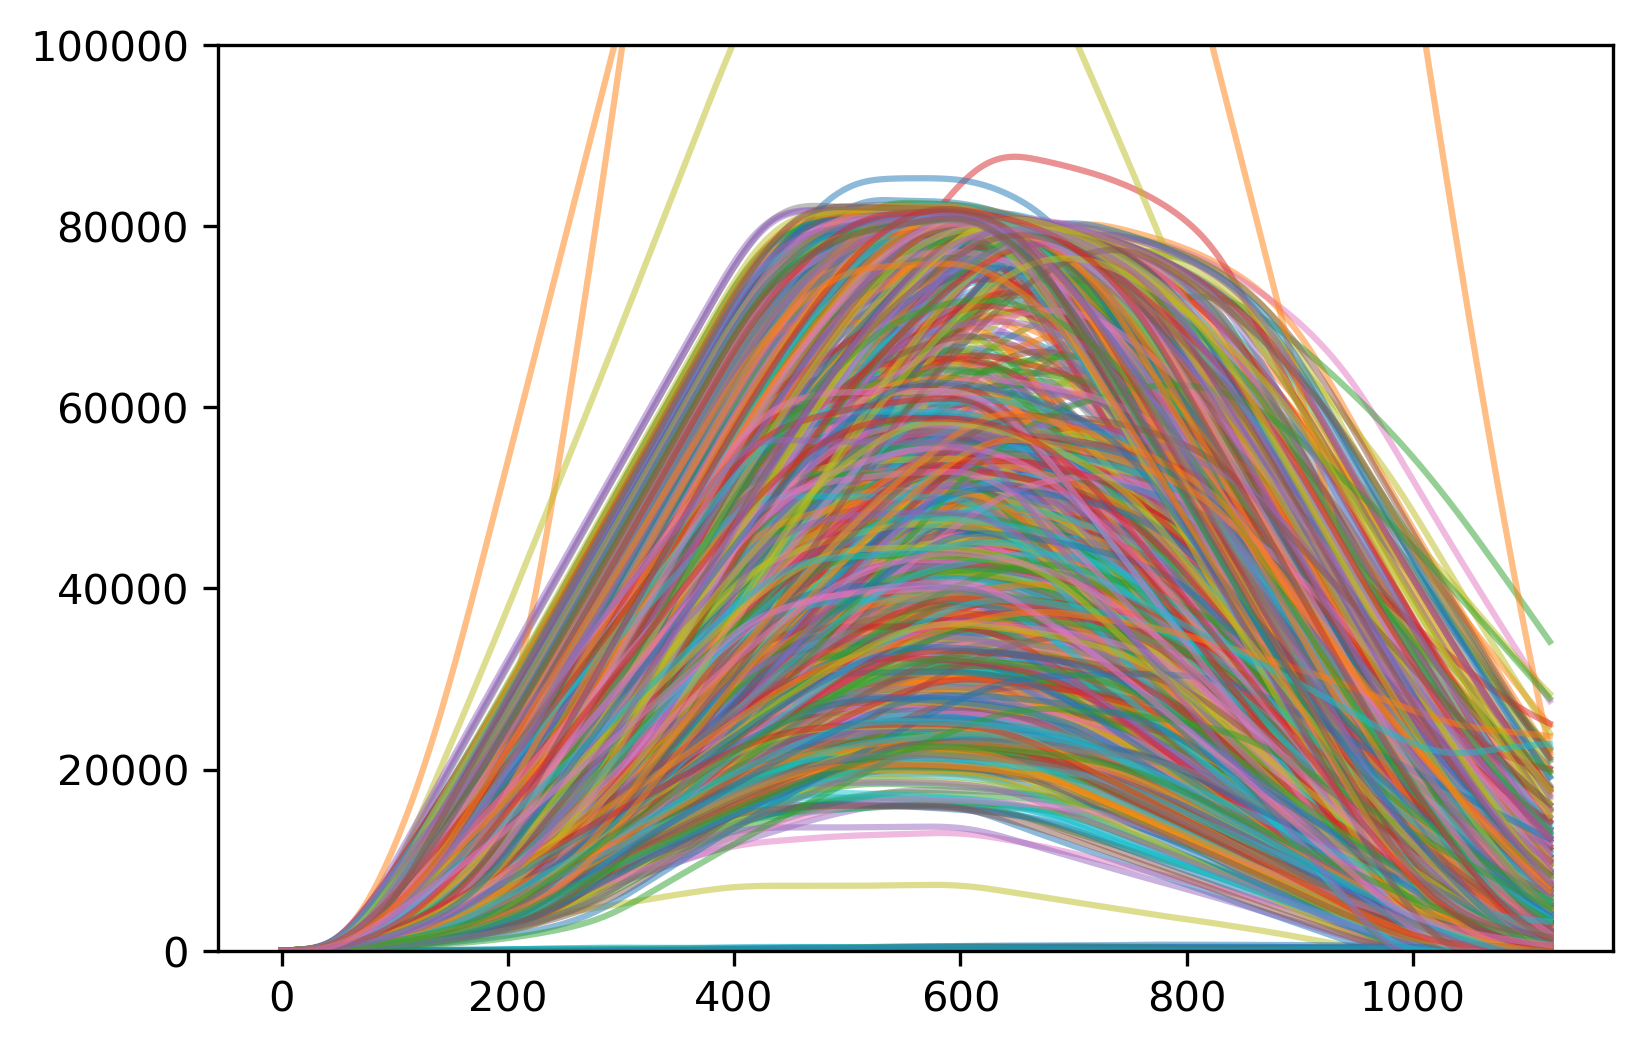

In [18]:
plt.figure(dpi=300)
for st in range(len(spec_trap)//16):
    plt.plot(spec_trap[st], alpha=0.5)
plt.ylim(0,1e5)
plt.show()

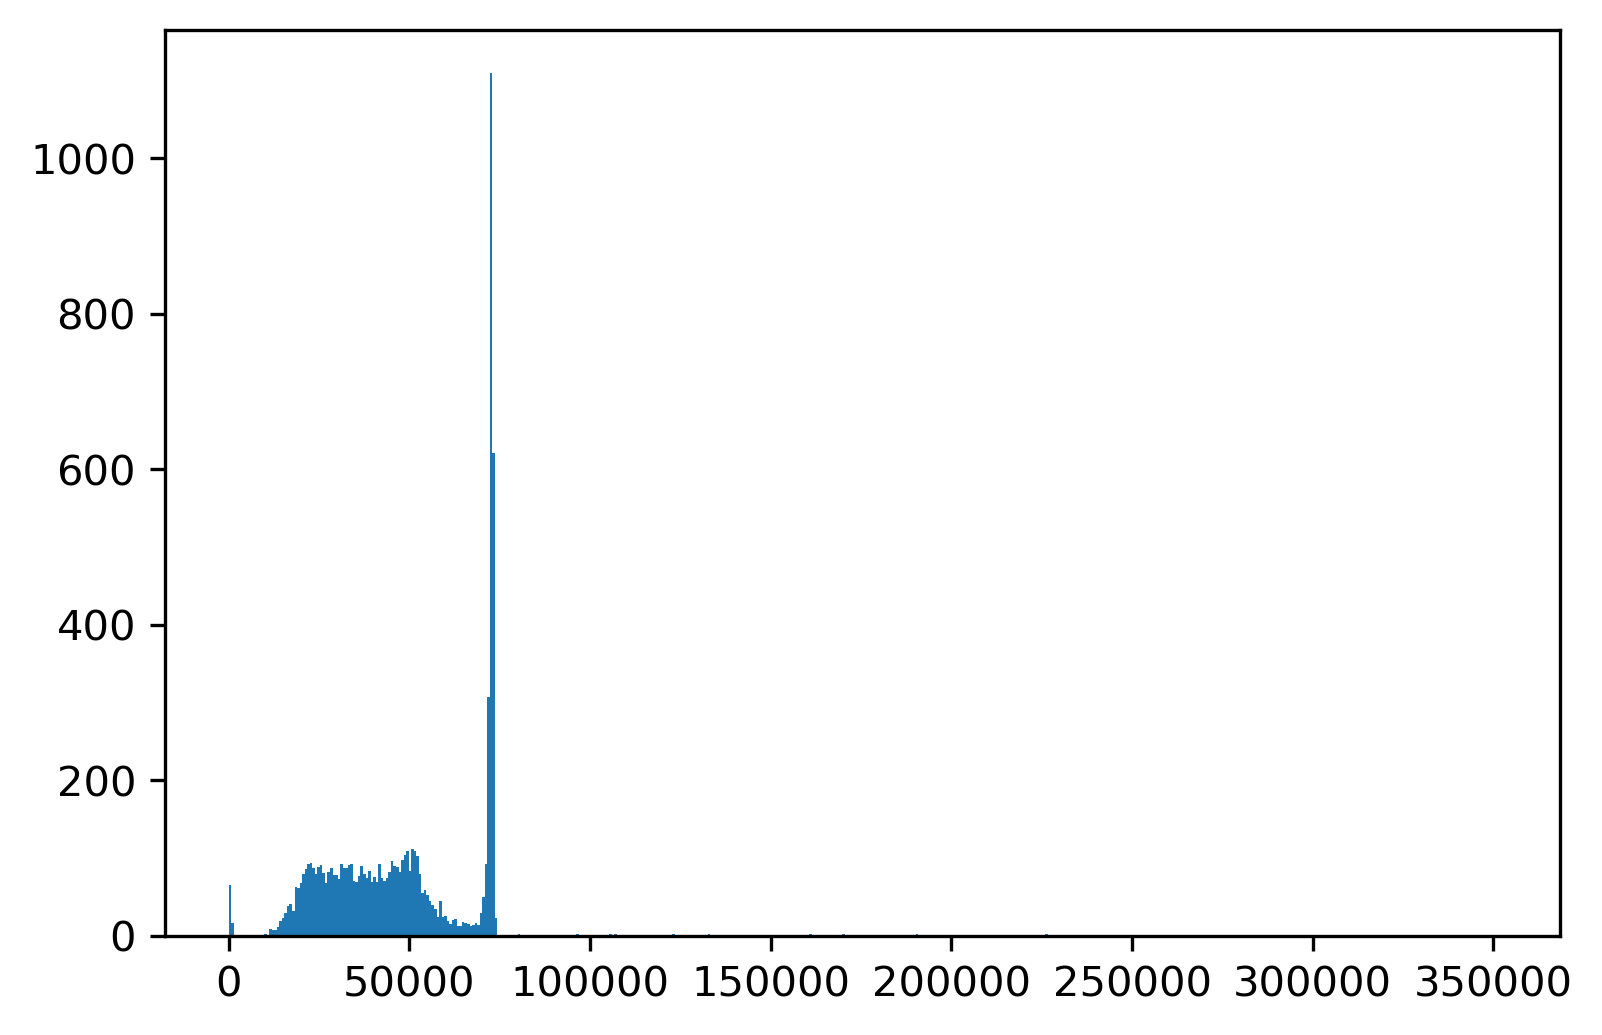

In [104]:
plt.figure(dpi=300)
plt.hist(spectra, bins=500)
#plt.semilogy()
plt.show()

In [32]:
test_traps = np.load('Data/Fit-Data-Old/Cs137_p370_g0.npy')

In [18]:
np.argwhere(np.gradient(test_traps[ind])==0)

array([], shape=(0, 1), dtype=int64)

In [57]:
st = time.time()

idk = savgol_filter(np.gradient(savgol_filter(np.gradient(test_traps[ind]), 51, 0)), 51, 0)

print(time.time()-st)

0.002032041549682617


In [37]:
spectra = []

for trap in test_traps:
    if max(trap) < 365000:
        spectra.append(max(trap))

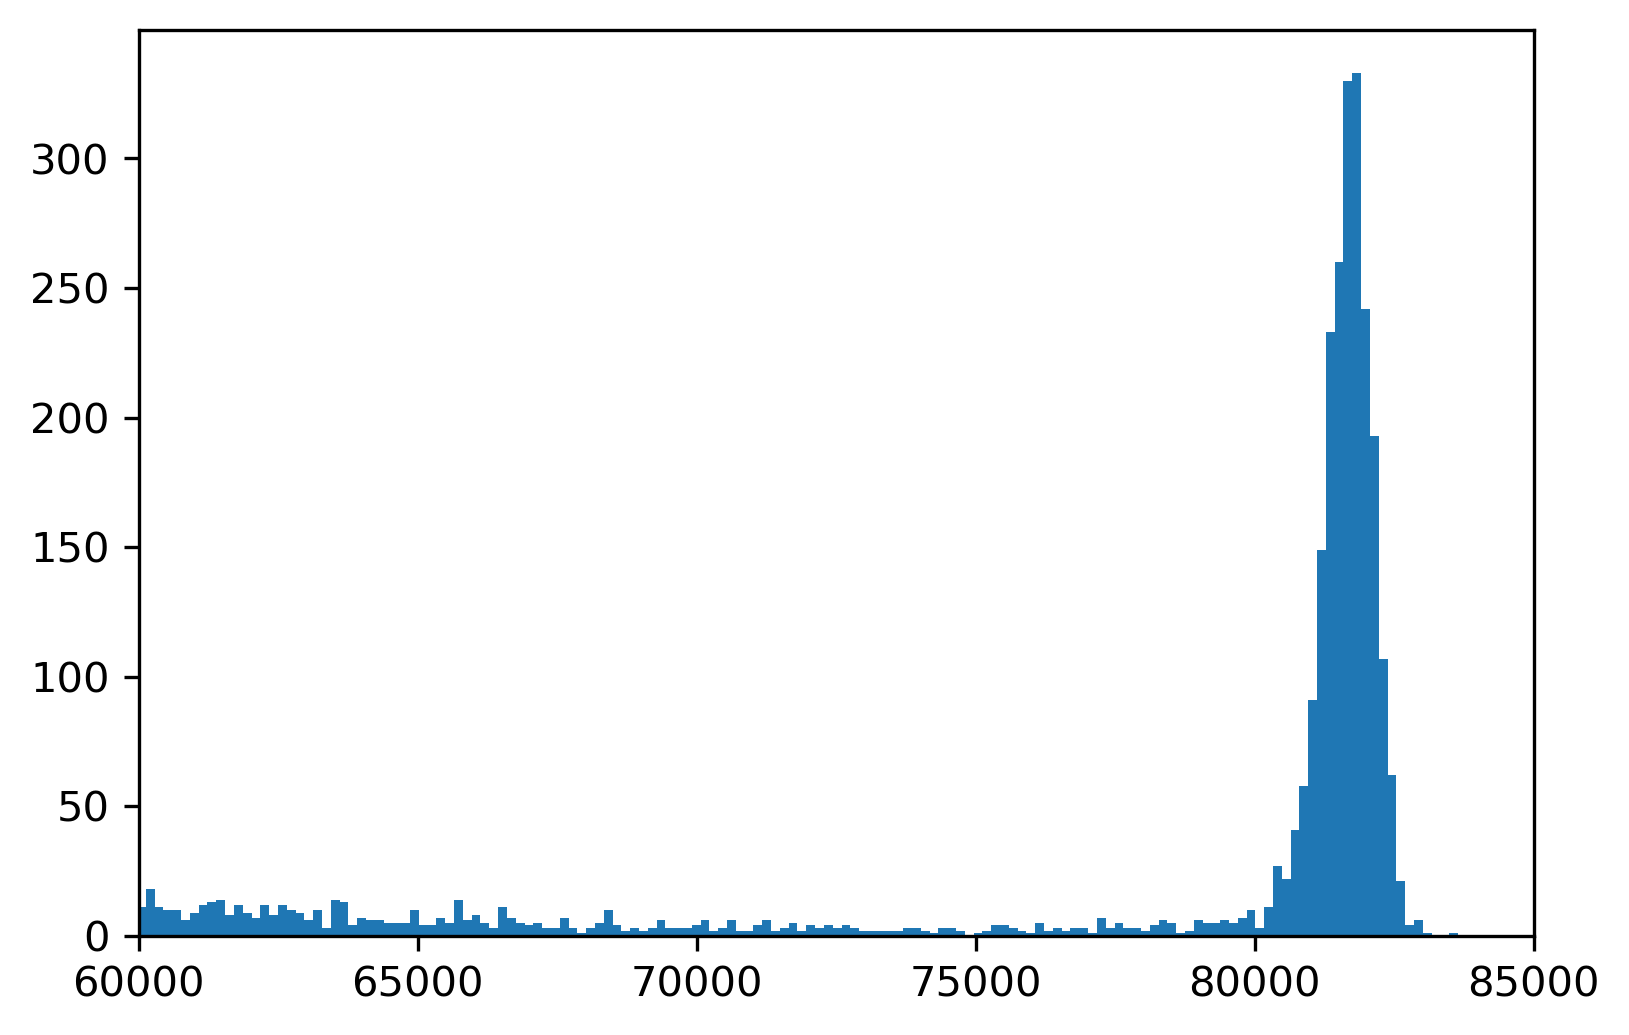

In [24]:
plt.figure(dpi=300)
plt.hist(spectra, bins=2**11)
#plt.semilogy()
plt.xlim(6e4, 8.5e4)
plt.show()

In [38]:
spe_hist = np.histogram(spectra, bins=2**11)

In [23]:
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [39]:
start = np.argmin(np.abs(spe_hist[1] - 6e4))
end = np.argmin(np.abs(spe_hist[1] - 8.5e4))

In [40]:
st = time.time()
test_gauss = gauss_fit(spe_hist[1][start:end], spe_hist[0][start:end])

print(time.time() - st)

0.007622718811035156


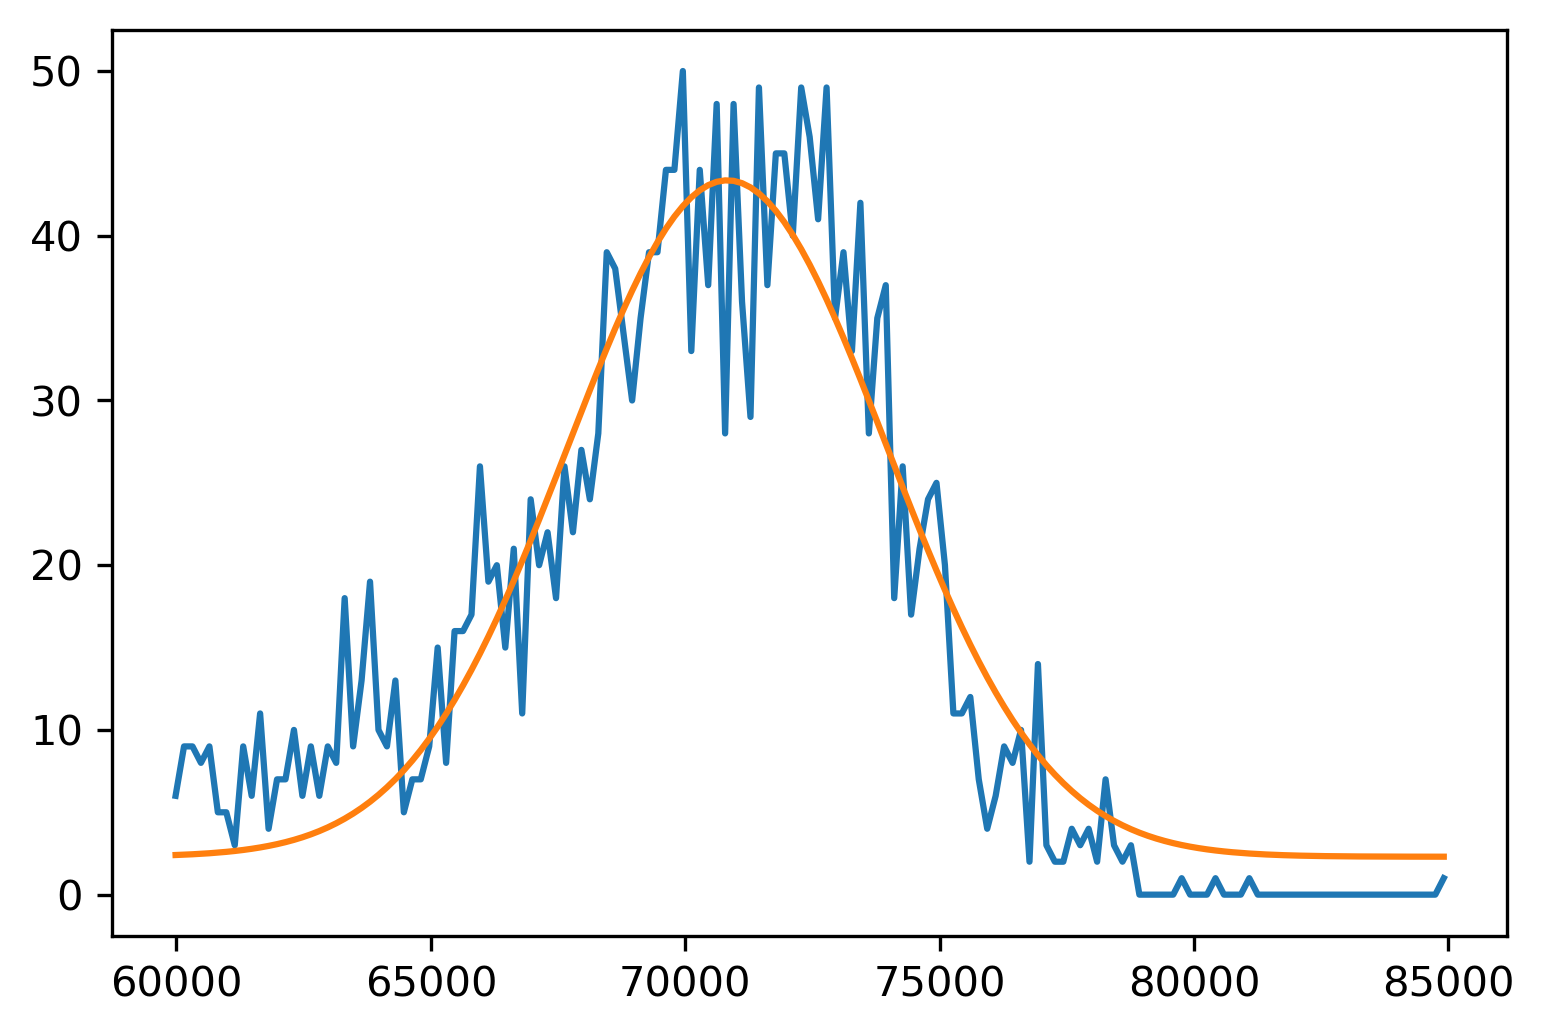

In [41]:
plt.figure(dpi=300)
plt.plot(spe_hist[1][start:end], spe_hist[0][start:end])
plt.plot(spe_hist[1][start:end], gauss(spe_hist[1][start:end], *test_gauss))
plt.show()

In [42]:
H, A, x0, sigma = test_gauss
FWHM = 2.35482 * sigma

print('The offset of the gaussian baseline is', H)
print('The center of the gaussian fit is', x0)
print('The sigma of the gaussian fit is', sigma)
print('The maximum intensity of the gaussian fit is', H + A)
print('The Amplitude of the gaussian fit is', A)
print('The FWHM of the gaussian fit is', FWHM)

The offset of the gaussian baseline is 2.3025468397141977
The center of the gaussian fit is 70827.0859055283
The sigma of the gaussian fit is 3134.6307355221047
The maximum intensity of the gaussian fit is 43.36548926945032
The Amplitude of the gaussian fit is 41.062942429736125
The FWHM of the gaussian fit is 7381.491148622163


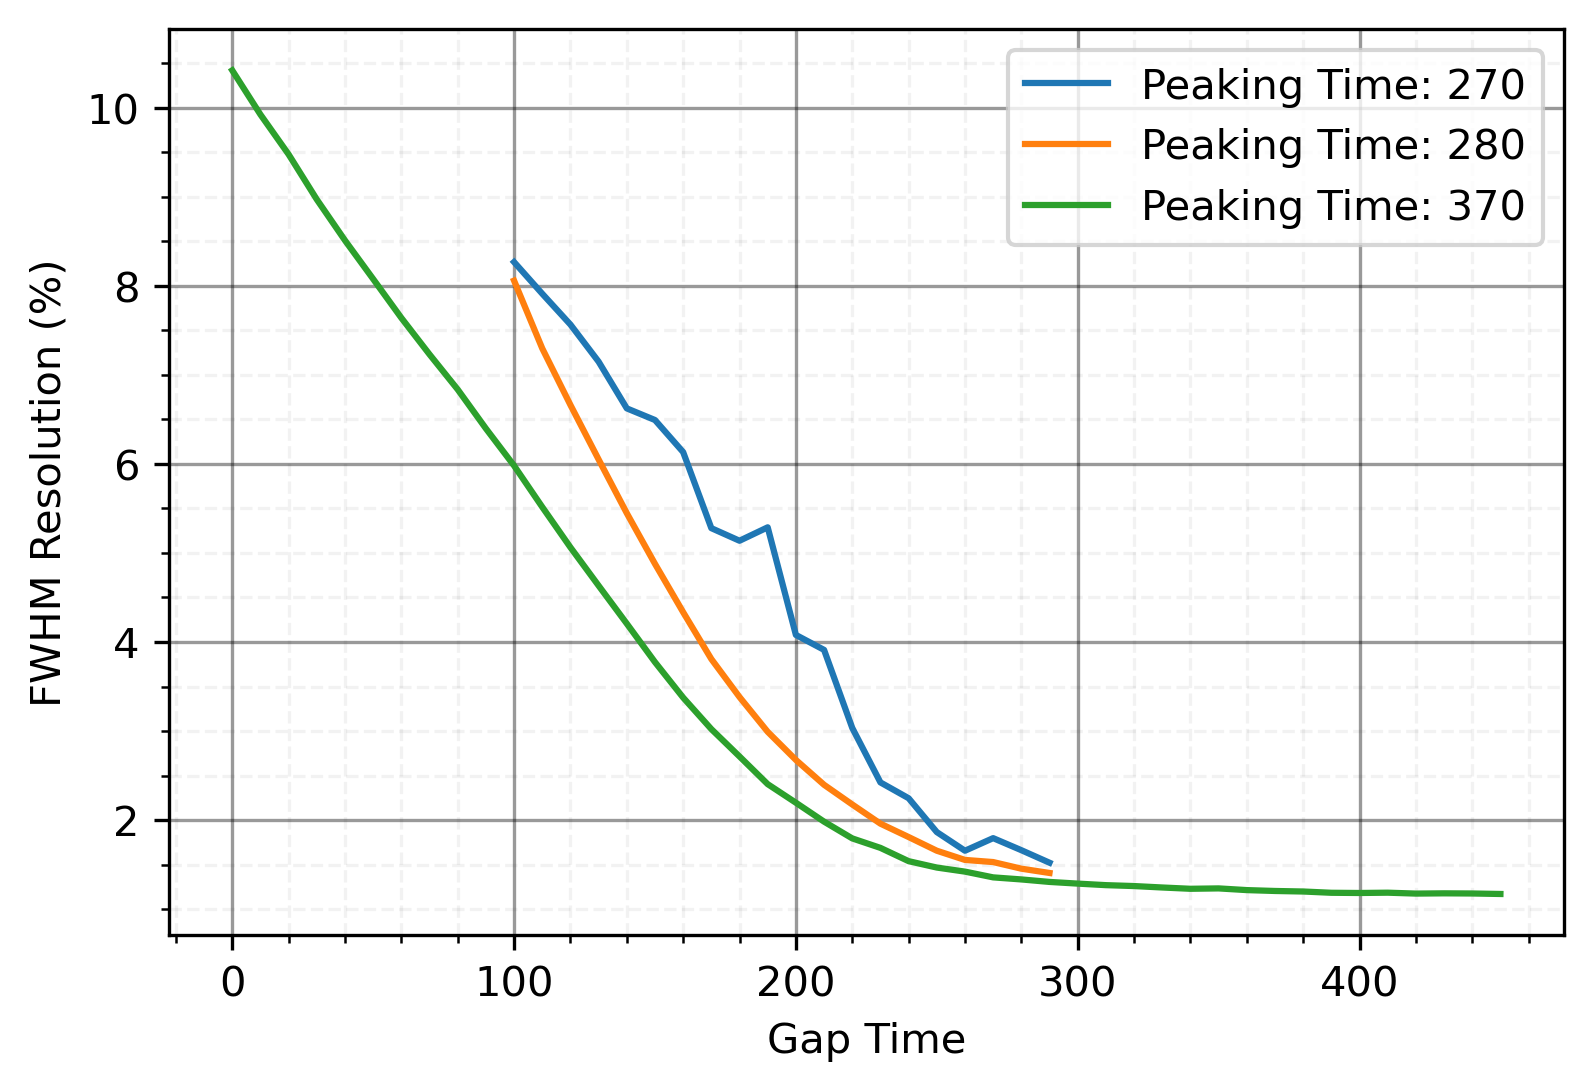

In [92]:
plt.figure(dpi=300)
plt.plot(gs_270, resolutions_270, label='Peaking Time: 270')
plt.plot(gs_280, resolutions_280, label='Peaking Time: 280')
plt.plot(gs, resolutions, label='Peaking Time: 370')
plt.legend()
plt.xlabel('Gap Time')
plt.ylabel('FWHM Resolution (%)')
plt.grid(which='major', color='k', linestyle='-', alpha=0.4)
plt.minorticks_on()
plt.grid(which='minor', color='k', linestyle='--', alpha=0.05)
plt.show()

In [95]:
os.listdir()

['.DS_Store',
 'Recursive-Trapezoid-Testing.ipynb',
 'Getk.ipynb',
 '__pycache__',
 'NE-204_Lab-1.ipynb',
 'multi_traps.py',
 '.ipynb_checkpoints',
 'Data',
 'Plots']

In [45]:
test_counts = np.load('Data/Cs137-Gauss-Fits/Counts-Old/p530_g-vary_counts.npy')
test_bins = np.load('Data/Cs137-Gauss-Fits/bins.npy')

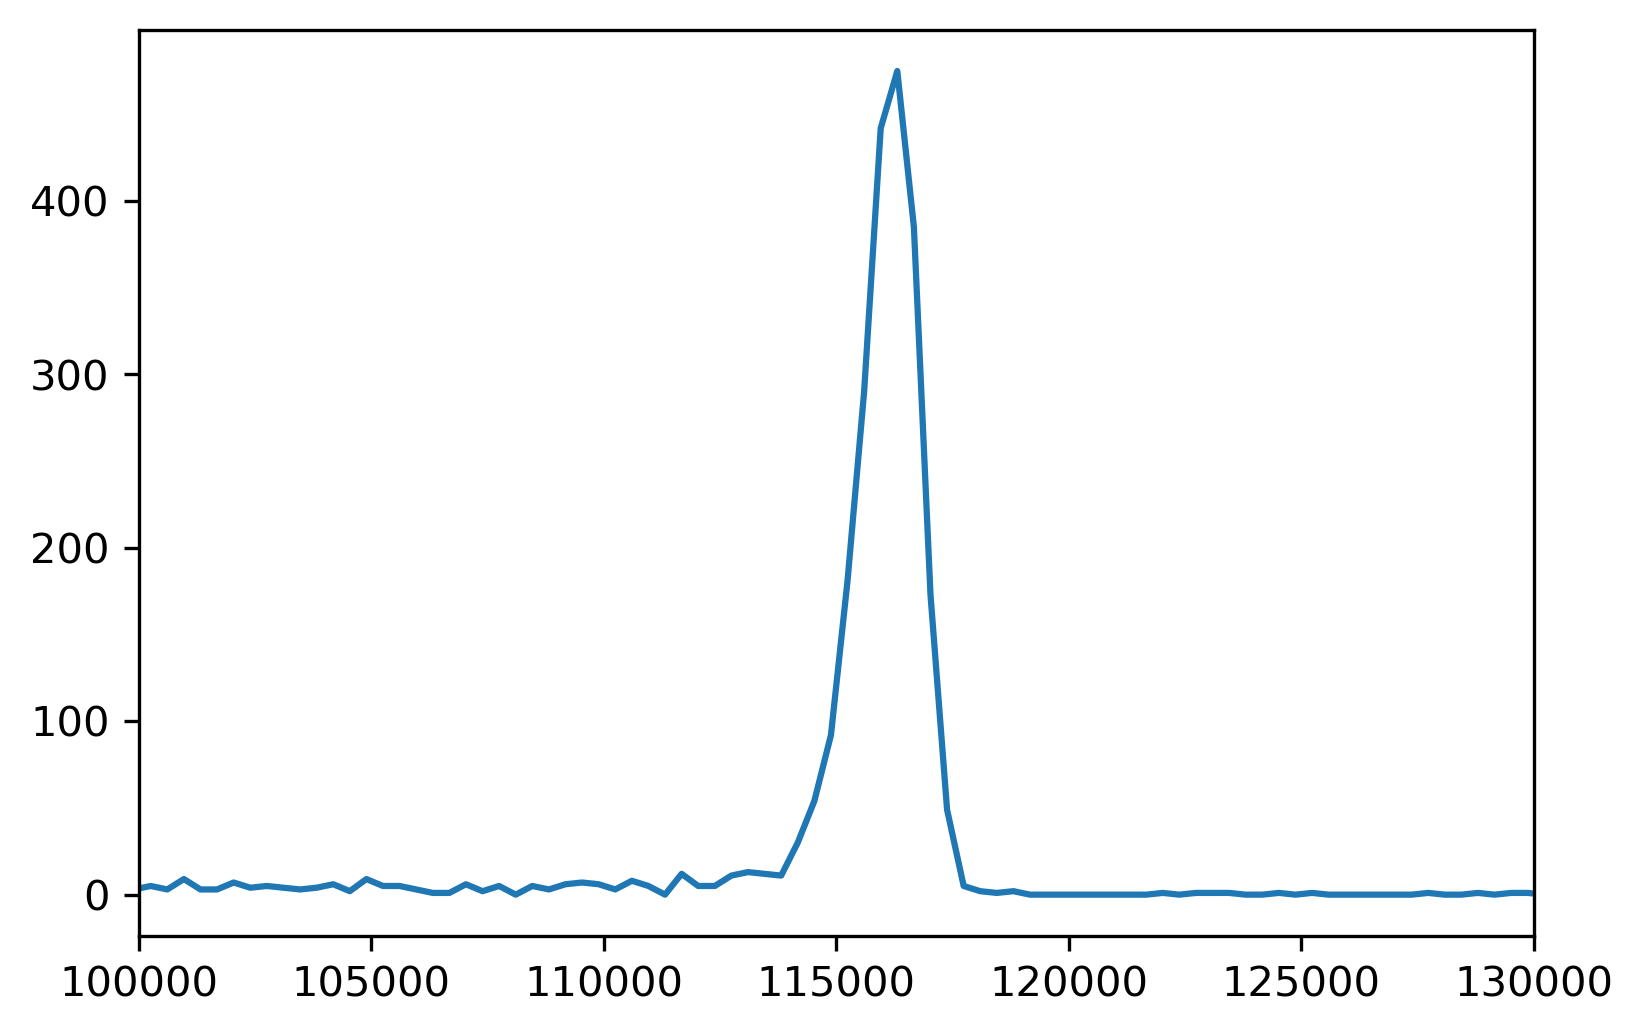

In [48]:
plt.figure(dpi=300)
plt.plot(test_bins[:-1], test_counts[50])
plt.xlim(1e5, 1.3e5)
plt.show()

  0%|          | 0/32 [00:00<?, ?it/s]

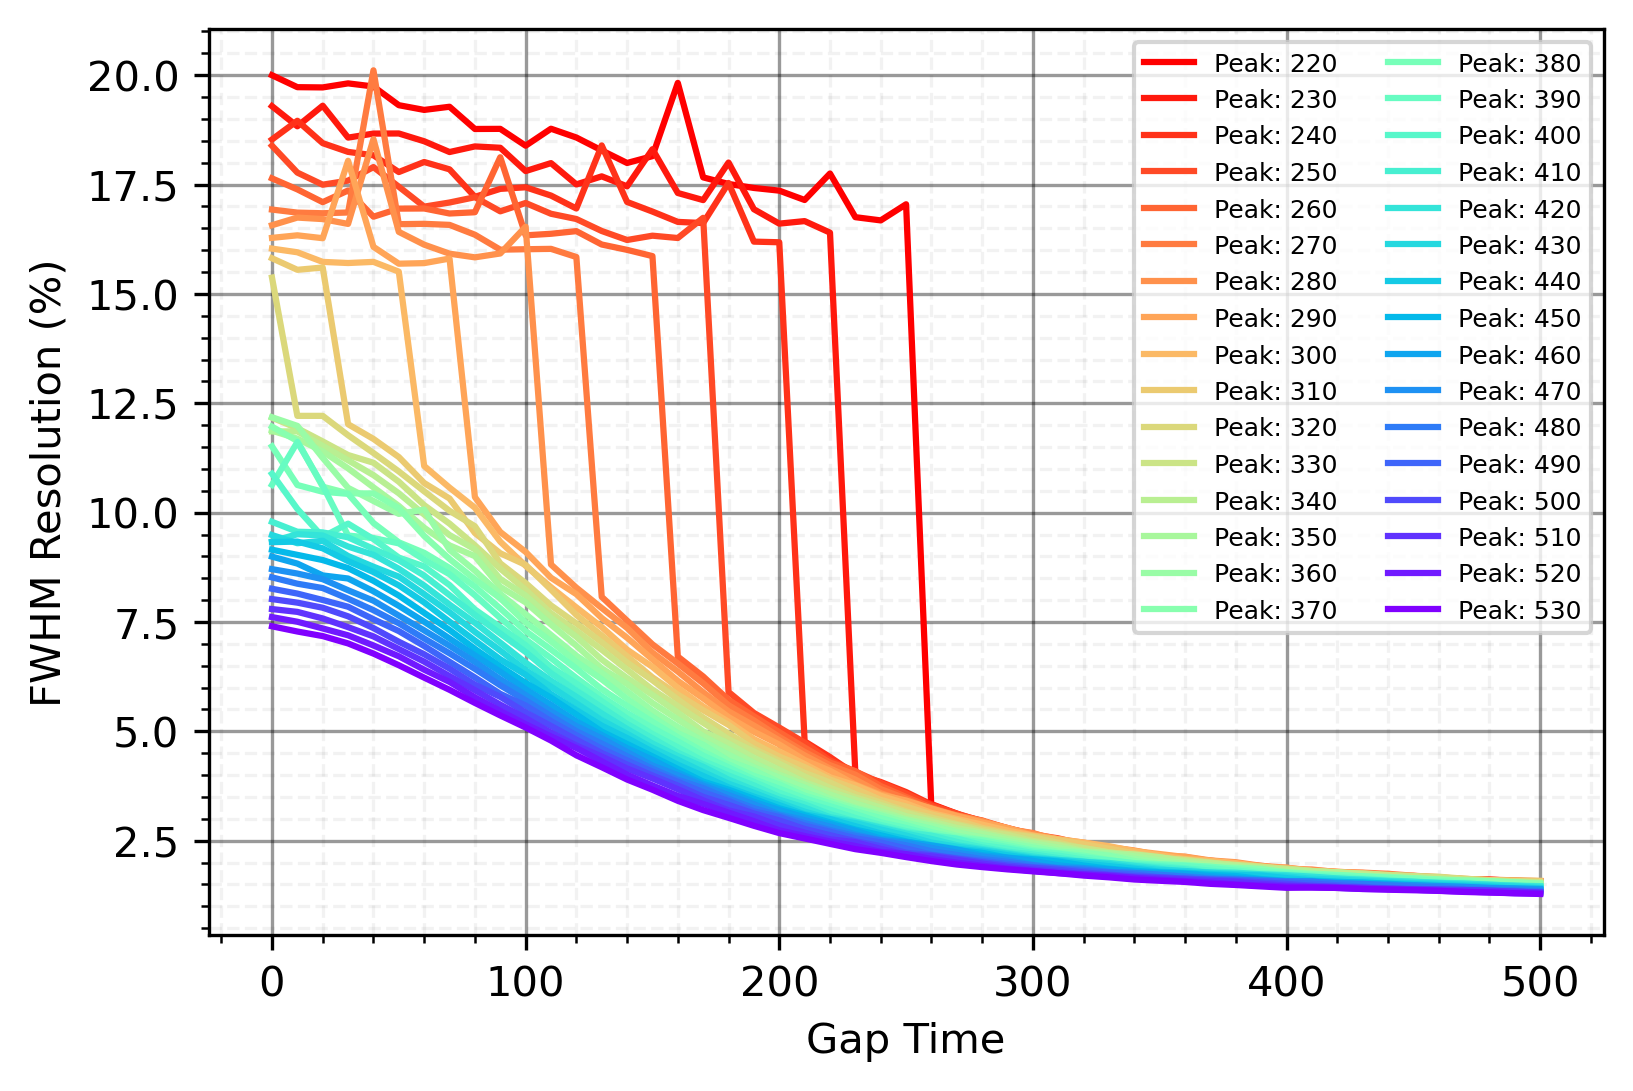

In [44]:
files = [[int(f.split('p')[1][:3]), 'Data/Cs137-Gauss-Fits/Fits-Old/'+f] for f in os.listdir('Data/Cs137-Gauss-Fits/Fits-Old/')]
files.sort()

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(1, 0, len(files)))

gs = list(range(0,510,10))

plt.figure(dpi=300)
for i, file in enumerate(tqdm(files)):
    gfr = np.load(file[1])
    
    resolutions = np.abs(((gfr[:,3]*2.35482)/gfr[:,2])*100)
    
    plt.plot(gs, resolutions, label='Peak: {}'.format(file[0]), color=colors[i])
plt.legend(fontsize=6, ncol=2)
plt.xlabel('Gap Time')
plt.ylabel('FWHM Resolution (%)')
plt.grid(which='major', color='k', linestyle='-', alpha=0.4)
plt.minorticks_on()
plt.grid(which='minor', color='k', linestyle='--', alpha=0.05)
plt.show()

In [134]:
def trapezoid(x, a, b, c, tau1, tau2):
    y = np.zeros(len(x))
    c = -np.abs(c)
    a = np.abs(a)
    (tau1,tau2) = (min(tau1,tau2),max(tau1,tau2))
    y[:int(tau1)] =  a*x[:int(tau1)] + b
    y[int(tau1):int(tau2)] =  a*tau1 + b 
    y[int(tau2):] = c*(x[int(tau2):]-tau2) + (a*tau1 + b)
    return y

def trapezoid_height(trapezoid_signal, tau1=400, tau2=800):
    popt, pcov = curve_fit(trapezoid, np.arange(len(trapezoid_signal)), trapezoid_signal, method = 'lm',
                      p0=[200, -8000, 200, tau1, tau2])
    trap_height = np.mean(trapezoid_signal[math.floor(popt[3]):math.ceil(popt[4])])
    return trap_height

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

def calibrate_energy(ch, a1, a2, a3, a4, a5, b):
    return a1*ch + a2*ch**2 + a3*ch**3 + a4*ch**4 + a5*ch**5 + b

In [133]:
#f = h5py.File('Data/Test-928/Co57-4in-2min.h5')
#f = h5py.File('Data/Test-928/Co60-36in-2min.h5')
#f = h5py.File('Data/Test-928/Cs137-24in-2min.h5')
f = h5py.File('Data/Test-928/Th228-24in-20min.h5')

test_data = pd.DataFrame(f['raw_data'])
test_np = test_data.to_numpy()

sat_i = []
for i in range(len(test_np)):
    if test_np[i][1300] == 16383:
        sat_i.append(i)
        
calib_consts = np.load('Data/calibration_fit.npy')

print(len(test_np))

22981


In [136]:
peak, gap = 530, 500
max_height = 519300

energies = []

warnings.filterwarnings("ignore")
for i, pulse in enumerate(tqdm(test_np, desc="Creating spectra")):
    fs = savgol_filter(pulse, 51, 0)
    try:
        trap_height = trapezoid_height(s(fs, determine_rise(fs), 15000, peak, gap))
    except:
        print('Index {} failed to fit trapezoid'.format(i))
        continue
        
    if not math.isnan(trap_height):
        if trap_height < max_height:
            energies.append(calibrate_energy(trap_height, *calib_consts))
energies = np.array(energies)

#cs_calib = 0.00569747732548954
#spectra_calib = spectra*cs_calib

Creating spectra:   0%|          | 0/22981 [00:00<?, ?it/s]

Index 9399 failed to fit trapezoid
Index 11008 failed to fit trapezoid
Index 14964 failed to fit trapezoid


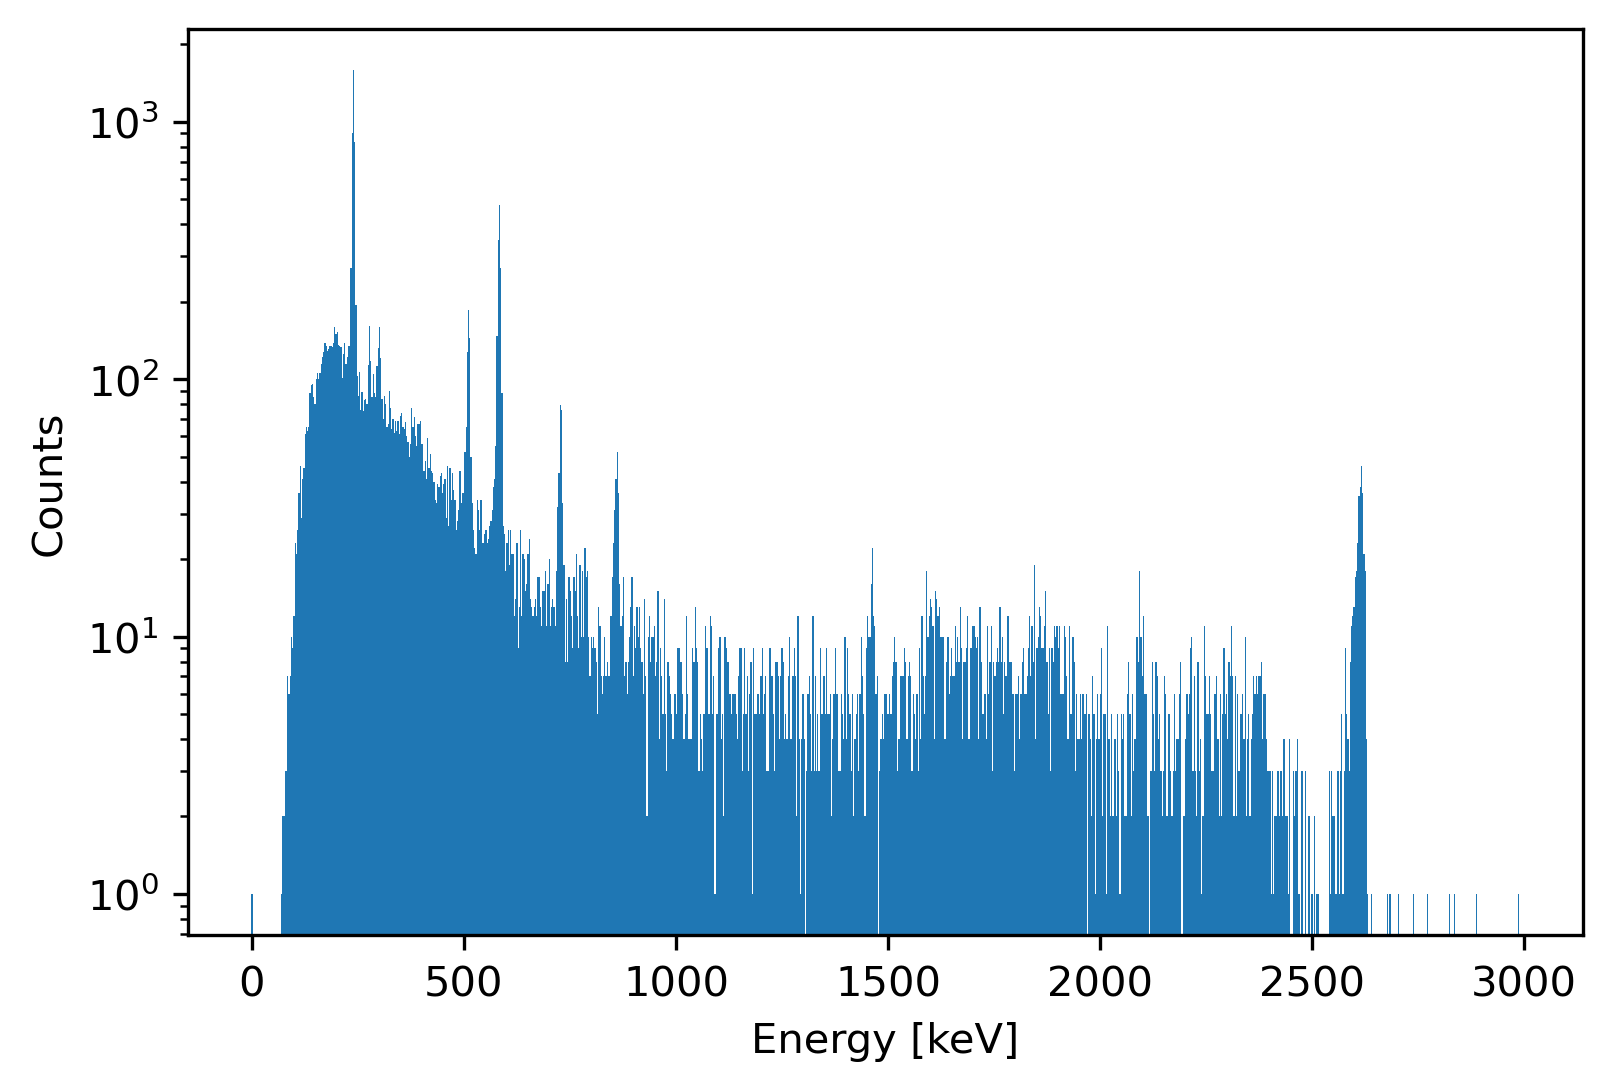

In [144]:
plt.figure(dpi=300)
counts, bins_out, patches = plt.hist(energies, bins=2**10)
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
plt.semilogy()
plt.show()

In [2]:
2**10

1024

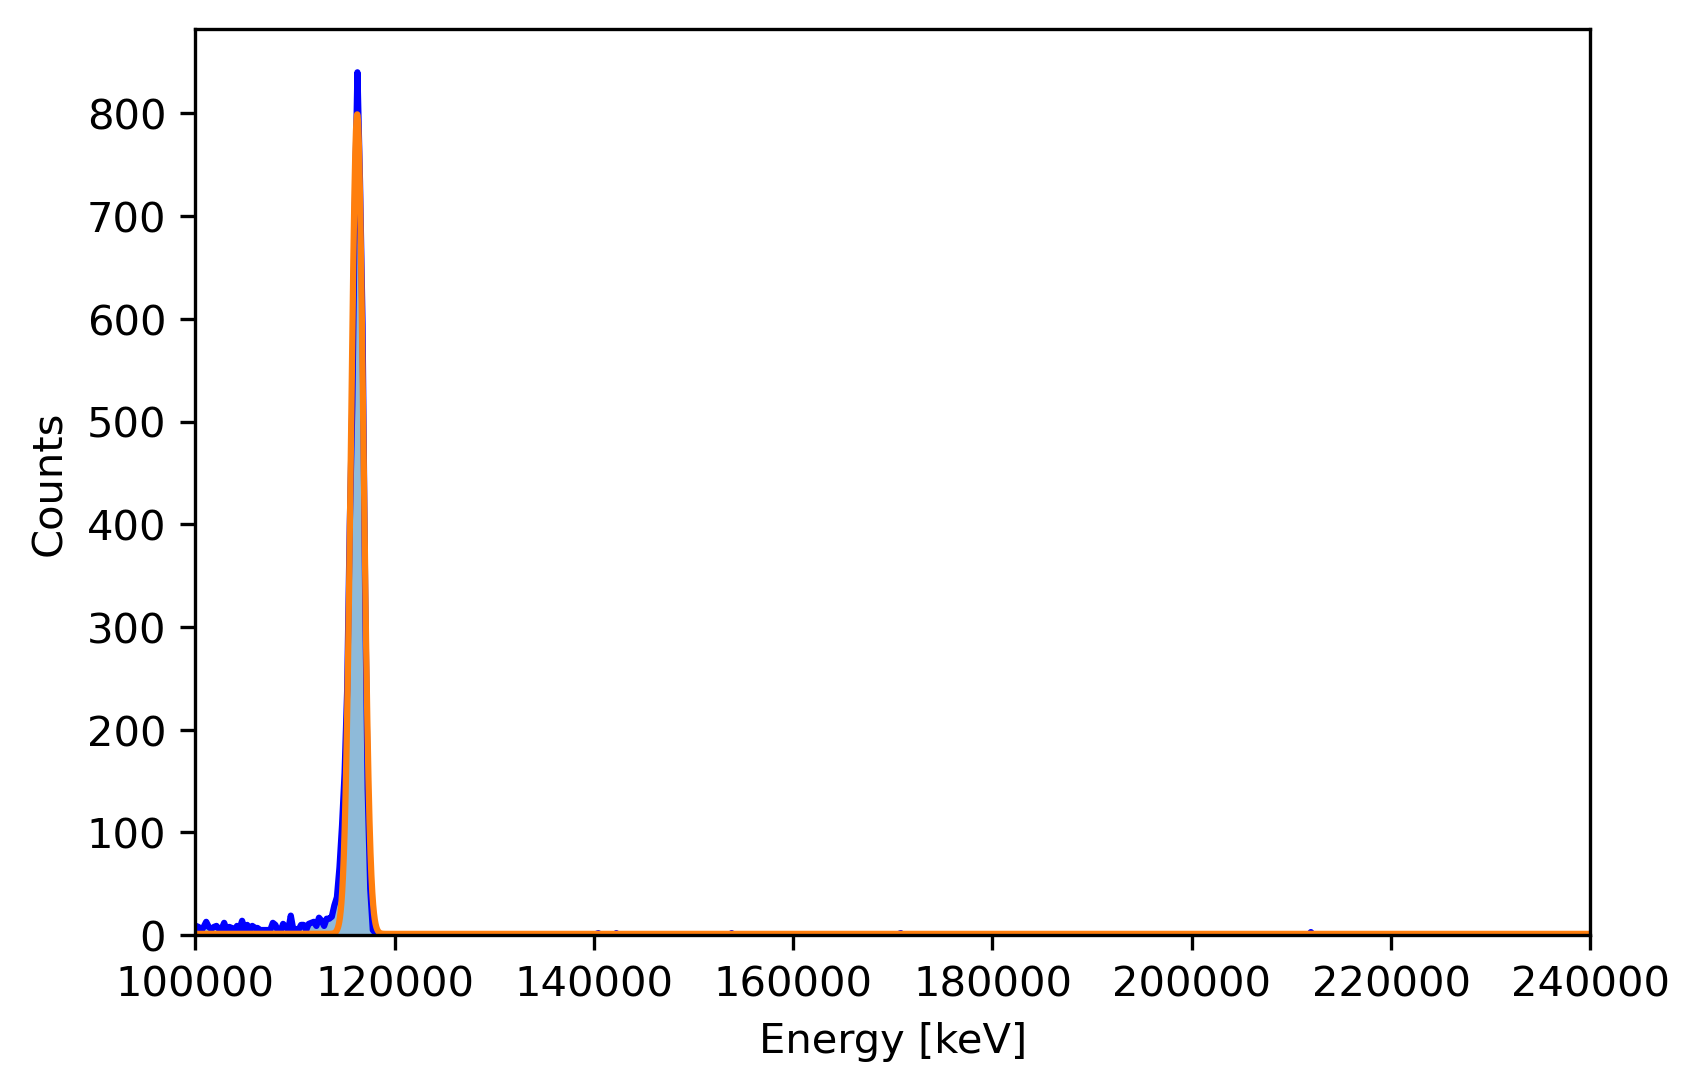

In [96]:
plt.figure(dpi=300)


bins_ = np.linspace(0,math.ceil(max_height),2**11)
#bins_ = np.linspace(0,3000,2**11)


counts, bins_out, patches = plt.hist(spectra, bins=bins_, alpha=0.5)
#counts, bins_out, patches = plt.hist(spectra_calib, bins=bins_, alpha=0.5)
#win_min, win_max = 0.90*bins[np.argmax(counts)], 1.4*bins[np.argmax(counts)]
#win_min, win_max = 800, 1200
win_min, win_max = 1e5, 2.4e5

start = np.argmin(np.abs(bins_out - win_min))
end = np.argmin(np.abs(bins_out - win_max))

gauss_result = gauss_fit(bins_out[start:end], counts[start:end])

plt.plot(bins_out[:-1], counts, c='b')

#plt.plot(gauss(np.arange(3000), *gauss_result))
plt.plot(gauss(np.arange(5e5), *gauss_result))
#plt.axvline(gauss_result[2], c='r')
plt.xlim(win_min, win_max)
#plt.xlim(1.5e4, 2.5e4)
#plt.semilogy()
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
plt.show()

#resolutions = np.abs(((gauss_result[3]*2.35482)/gauss_result[2])*100)

In [97]:
gauss_result[2]

116245.15536960539

In [99]:
cs_calib = 662/gauss_result[2]

In [100]:
cs_calib

0.00569747732548954

In [104]:
bins_calib = cs_calib*bins[:-1]

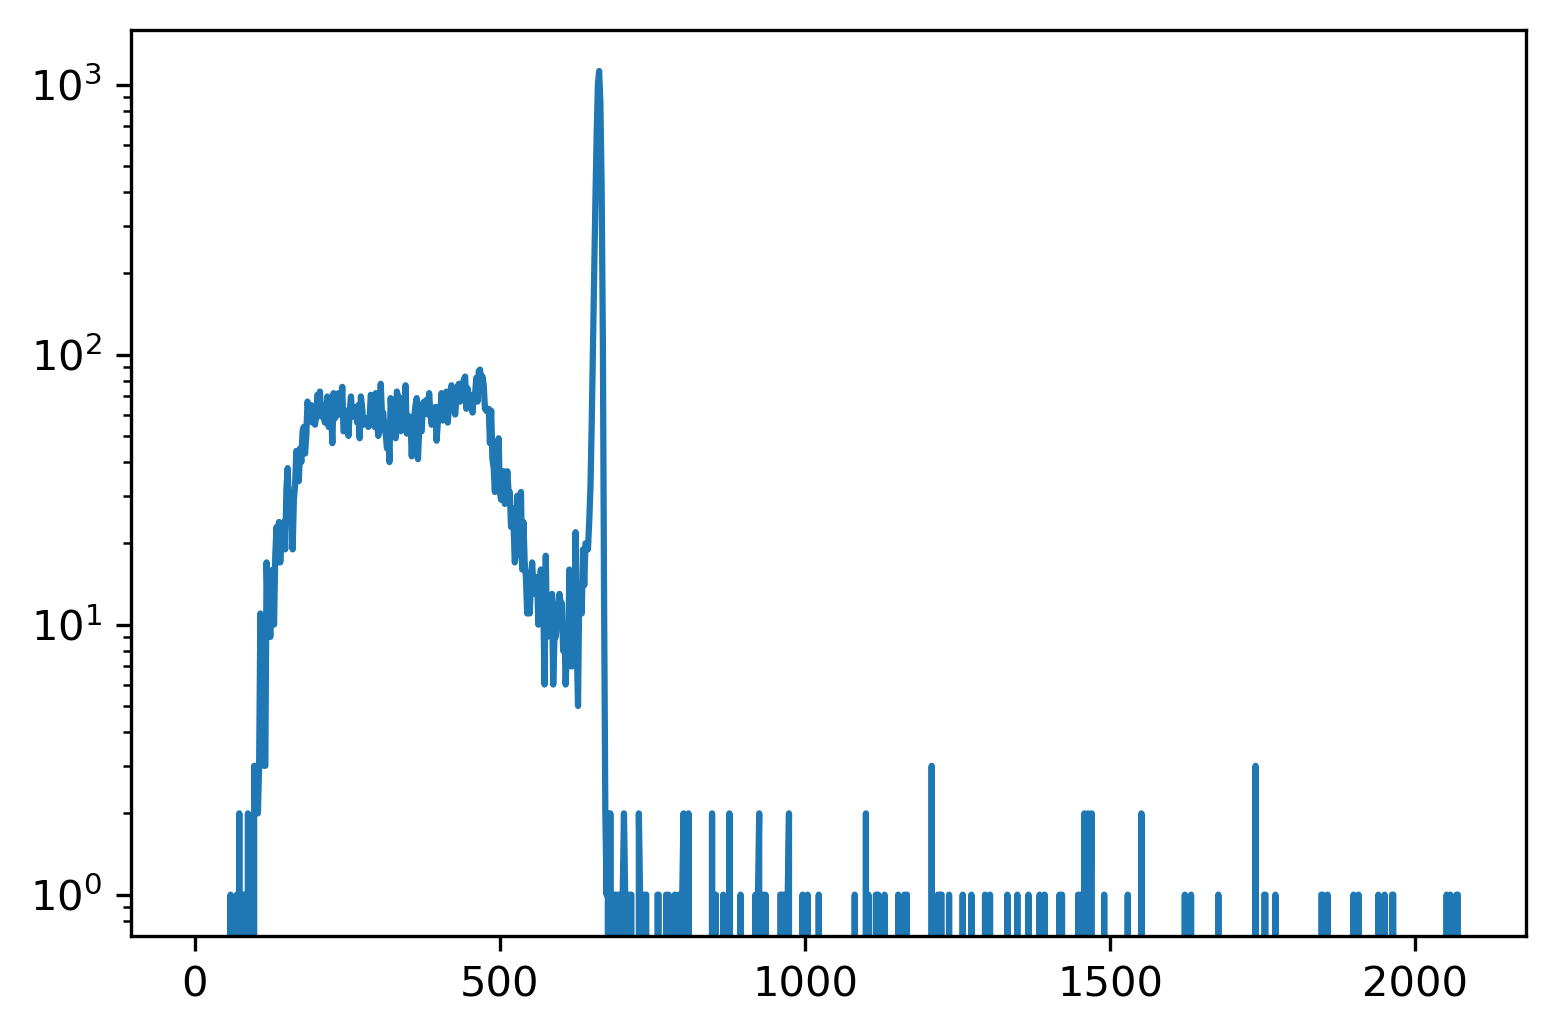

In [106]:
plt.figure(dpi=300)
plt.plot(bins_calib, counts)
plt.semilogy()
plt.show()

In [124]:
calib_const = np.load('Data/calibration_fit.npy')

In [127]:
max_ = np.argmin(np.abs(calibration_curve(np.arange(6e5), *calib_const)-3000))

In [130]:
np.arange(6e5)[max_]

519299.0